<a href="https://colab.research.google.com/github/sivavee/tsprediction/blob/dev/tsprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fbprophet

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark


In [3]:
!pip install pyarrow==0.15.1


     |████████████████████████████████| 59.2MB 78kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [4]:
import pyarrow
print(pyarrow.__version__)

0.15.1


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

In [6]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [7]:
%load_ext google.colab.data_table

In [26]:
%%bigquery --project circular-matrix-300010 df_state
SELECT date as ds, country_code,subregion1_code, sum(COALESCE(NULL, new_confirmed,0)) as y  FROM `bigquery-public-data.covid19_open_data.covid19_open_data` where country_code like 'IN' and subregion1_code is not null group by date, country_code,subregion1_code 

In [ ]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592956 entries, 0 to 592955
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ds               592956 non-null  object 
 1   country_code     592956 non-null  object 
 2   subregion1_code  503048 non-null  object 
 3   y                335768 non-null  float64
dtypes: float64(1), object(3)
memory usage: 18.1+ MB


In [34]:
%%bigquery --project circular-matrix-300010 df_country
SELECT date as ds, country_code,subregion1_code, sum(COALESCE(NULL, new_confirmed,0)) as y  FROM `bigquery-public-data.covid19_open_data.covid19_open_data` where country_code like 'IN' and subregion1_code is not null group by date, country_code,subregion1_code  having y>0 order by country_code,subregion1_code,date 

In [ ]:
df_country.describe()

,y
count,363.000000
mean,73119.355372
std,73354.100220
min,-1355.000000
25%,605.000000
50%,52352.000000
75%,139959.000000
max,233913.000000


In [9]:
import pandas as pd
from fbprophet import Prophet

m = Prophet(daily_seasonality=False,weekly_seasonality=True,yearly_seasonality=True)
m.fit(df_country)

NameError: ignored

In [ ]:
future_pd = m.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
)
forecast_pd = m.predict(future_pd)
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
449,2021-03-25,32798.999485,20691.590262,45380.308211
450,2021-03-26,33289.853239,21614.603905,44624.023770
451,2021-03-27,31723.780090,19874.367662,43661.152300
452,2021-03-28,26927.589709,14849.728422,38385.266172
453,2021-03-29,23317.935051,11617.603826,36052.464876


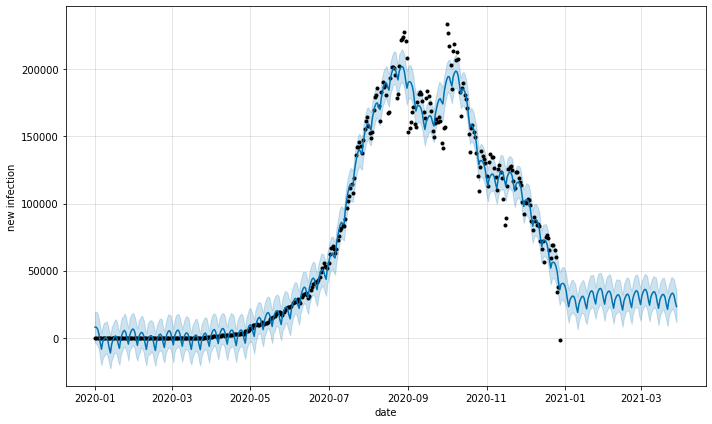

In [ ]:
predict_fig = m.plot(forecast_pd, xlabel='date', ylabel='new infection')
#display(predict_fig)

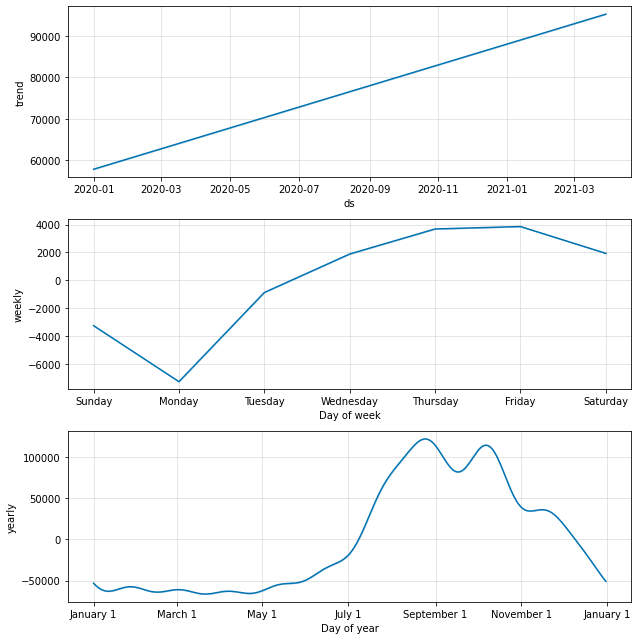

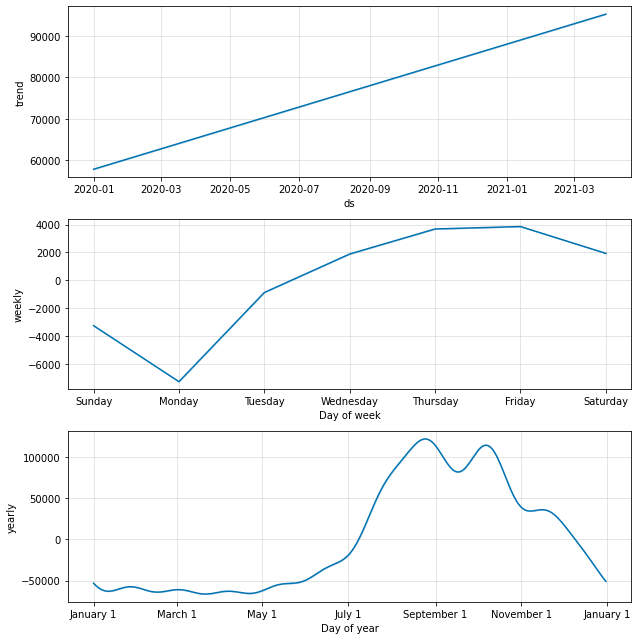

In [ ]:
m.plot_components(forecast_pd)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

# get historical actuals & predictions for comparison
actuals_pd = df_country[ df_country['ds'] < date(2020, 12, 1) ]['y']
predicted_pd = forecast_pd[ forecast_pd['ds'] < date(2020, 12, 1) ]['yhat']

# calculate evaluation metrics
mae = mean_absolute_error(actuals_pd, predicted_pd)
mse = mean_squared_error(actuals_pd, predicted_pd)
rmse = sqrt(mse)

# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

TypeError: ignored

In [35]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SQLContext 
sc = SparkContext("local", "App Name")
sql = SQLContext(sc)


ValueError: ignored

In [36]:
spark_df = sql.createDataFrame(df_state)

In [22]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *
from fbprophet import Prophet

result_schema =StructType([
  StructField('ds',DateType()),
  StructField('country_code',StringType()),
  StructField('subregion1_code',StringType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])


@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_cc_st(history_pd):
    from fbprophet import Prophet

    # instantiate the model, configure the parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    # fit the model
    model.fit(history_pd)

    # configure predictions
    future_pd = model.make_future_dataframe(
        periods=90,
        freq='d',
        include_history=True
    )

    # make predictions
    results_pd = model.predict(future_pd)

    # --------------------------------------
  
    # ASSEMBLE EXPECTED RESULT SET
    # --------------------------------------
    # get relevant fields from forecast
    f_pd = results_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
    # get relevant fields from history
    h_pd = history_pd[['ds','country_code','subregion1_code','y']].set_index('ds')
  
    # join history and forecast
    results_pd = f_pd.join( h_pd, how='left' )
    results_pd.reset_index(level=0, inplace=True)
  
    # get store & item from incoming data set
    results_pd['country_code'] = history_pd['country_code'].iloc[0]
    results_pd['subregion1_code'] = history_pd['subregion1_code'].iloc[0]
    # --------------------------------------
  
    # return expected dataset
    return results_pd[ ['ds', 'country_code', 'subregion1_code', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

In [37]:
from pyspark.sql.functions import current_date

results = (
  spark_df
    .groupBy('country_code', 'subregion1_code')
    .apply(forecast_cc_st)
    .withColumn('training_date', current_date() )
    )

results.createOrReplaceTempView('new_forecasts')



/content/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [38]:
display(results)

DataFrame[ds: date, country_code: string, subregion1_code: string, y: float, yhat: float, yhat_upper: float, yhat_lower: float, training_date: date]

In [39]:
results.write.format("csv").mode("overwrite").save("covid_in_forecast.csv")

In [ ]:
# Insert into big query Will work only if billing is enabled
%%bigquery --project circular-matrix-300010 df_state
#create table if not exists covid_in.forecasts (   date date,   country_code STRING,  subregion1_code STRING,   new_infection float64,   new_infection_predicted float64,   new_infection_predicted_upper float64,   new_infection_predicted_lower float64,   training_date date   ) PARTITION BY training_date;

-- load data to it
insert into forecasts
select 
  ds as date,
  country_code,
  subregion1_code,
  y as sales,
  yhat as sales_predicted,
  yhat_upper as sales_predicted_upper,
  yhat_lower as sales_predicted_lower,
  training_date
from new_forecasts;

Executing query with job ID: ebb32113-36c8-4c36-8322-93abf868cf53
Query executing: 0.17s


ERROR:
 403 Billing has not been enabled for this project. Enable billing at https://console.cloud.google.com/billing. DML queries are not allowed in the free tier. Set up a billing account to remove this restriction.

(job ID: ebb32113-36c8-4c36-8322-93abf868cf53)

                                                                                                                                           -----Query Job SQL Follows-----                                                                                                                                           

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:#create table if not exists covid_in.forecasts (   date date,   country_code STRING,  subregion1_code STRING, 

# New Section